# Nearest Neighbors Notebook

This notebook illustrate the use of the nearest neighbor classifier using scikit-learn. We will analyze the prediction accuracy of this classifier and also the decision boundaries generated by it.A grid search is used to test different hyper-parameter values (number of neighbors). The performance is evaluated using an inner cross validation method, and the fitted classifier is then evaluated on an independent test set.

First, we import the required libraries and packages.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import urllib.request as urllib

### Loading the Data

We load the data from a CSV file using pandas. The dataset considered is 'Wisconsin Diagnostic Breast Cancer' from the UCI repository. We ignore the first attribute in this dataset, which corresponds to the ID of each sample. The task of interest is to predict whether or not a cell corresponds to a malignant tumor. In this dataset all attributes take real values. These include area, smoothness, perimeter, etc.

In [4]:
data = pd.read_csv('wdbc.csv')
X = data.values[ :, 2:].astype(float)
y = (data.values[ :, 1 ] == 'B').astype(int)

### Data Partition into Train and Test

We randomly split the data into train and test partitions. We use 70% of the data for training and 30% for testing. 


In [5]:
X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.3, random_state=1)

### Data Standardization


We standardize the data to have zero mean and unit standard deviation.

In [6]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We check the standardization process.

In [7]:
print(np.var(X_train[:,0]))
print(np.var(X_train[:,1]))
print(np.var(X_train_scaled[:,0]))
print(np.var(X_train_scaled[:,1]))

12.278987535686415
18.99872174558559
0.9999999999999997
0.9999999999999999


## Choosing good vales for the number of neighbors

A critical step is choosing hyper-parameter values that are expected to perform well. We do that here by using an inner cross validation step combined with a grid search. We use a classifier, i.e., K-Nearest-Neighbors, and will have to choose the number neighbors used.

### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the inner cross validation procedure. If required, in this pipeline we may also consider extra data transformations such as additional standardization steps for each partition of the data. We omit this step here.

In [8]:
pipeline = Pipeline([ ('knn', KNeighborsClassifier()) ])

### Indicating Potential Values for the Hyperparameters

We specify values for the hyperparameters of the classifier. In this case, the number of neighbors to consider.

In [9]:
N_neighbors = [1, 3, 5, 7, 11, 15, 20, 25, 30]
param_grid = { 'knn__n_neighbors': N_neighbors }

### Evaluating the Performance for each Value of the Hyperparameters

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv.

In [10]:
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_train_scaled, y_train)

### Obtaining the Results

We get the mean accuracy and the corresponding standard deviation across data splits.

In [11]:
accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']

We also obtain the accuracy on the test set for comparison purposes.

In [12]:
test_accuracies = np.ones(len(N_neighbors))

for i in range(len(N_neighbors)):
    knn = KNeighborsClassifier(n_neighbors = N_neighbors[ i ])
    knn.fit(X_train_scaled, y_train)
    test_accuracies[ i ] = accuracy_score(knn.predict(X_test_scaled), y_test)

### Plotting the Results

For a better visualization of the average results, we plot them, showing also the corresponding standard deviation estimate.

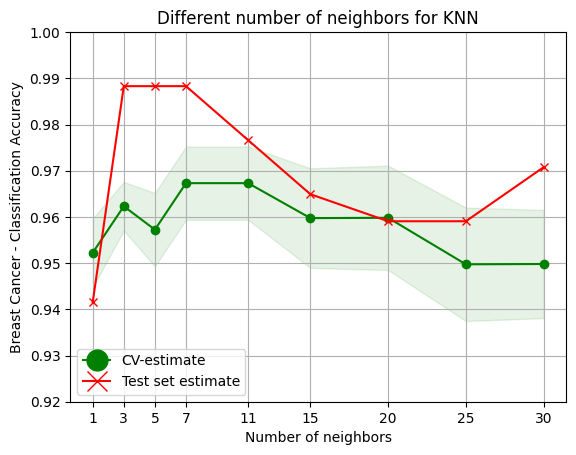

In [13]:
plt.figure()
line1, = plt.plot(N_neighbors, accuracies, 'o-', color="g")
line2, = plt.plot(N_neighbors, test_accuracies, 'x-', color="r")
plt.fill_between(N_neighbors, accuracies - std_accuracies / np.sqrt(10), \
    accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
plt.grid()
plt.title("Different number of neighbors for KNN")
plt.xlabel('Number of neighbors')
plt.xticks(np.array(N_neighbors))
plt.ylabel('Breast Cancer - Classification Accuracy')
plt.ylim((0.92, 1.0))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate')]
plt.legend(handles=legend_handles, loc = 3)
plt.show()

We can observe that the best prediction accuracy is obtained for K = 7, although there seem to be small differences among all values.

## Fitting the Final Model and Estimating Its Performance


For this step, we use the whole training data available and the best observed parameter value. 

We train the classifier.

In [14]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7)

### Evaluating the Performance on the Test Set

We compute the confusion matrix on the test set.

In [15]:
y_pred = knn.predict(X_test_scaled)

In [16]:
conf = confusion_matrix(y_test, y_pred)

In [17]:
# The matrix conf contains:
# TN | FN
# FP | TP

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[ 52   2]
 [  0 117]]
Predicion accuracy is: 0.988304
True postive rate is: 1.000000
True negative rate is: 0.962963



## Classification Frontier Visualization

We show how the decision boundaries of the classifier look like for different values of the hyper-parameters. For simplicity, we only consider the first two attributes of the previous problem. We use all the available data.

In [18]:
X = X[:, [0, 1]]

As previously, the first step is to standardize the data. 

In [19]:
X_scaled = preprocessing.scale(X)

We check that the standardization process has been successful.

In [20]:
print(np.var(X[:,0]))
print(np.var(X[:,1]))
print(np.var(X_scaled[:,0]))
print(np.var(X_scaled[:,1]))

12.39260536964082
18.358905874020532
1.0
0.9999999999999998


We plot the data we are going to train the classifier on.

In [21]:
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5

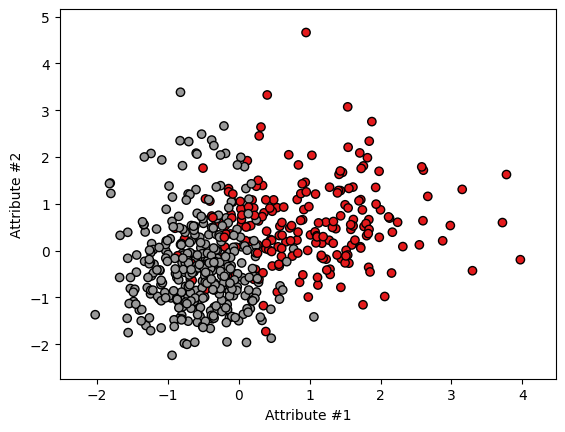

In [22]:
plt.figure()
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We train the classifier for different values of the K parameter [1, 3, 30 ] and look at the results. 

In [23]:
k = [ 1, 3, 30 ]
knn_classifiers = [ KNeighborsClassifier(n_neighbors=x) for x in k ]

for i in range(len(knn_classifiers)):
    knn_classifiers[ i ].fit(X_scaled, y)

We plot the resulting decision boundaries.

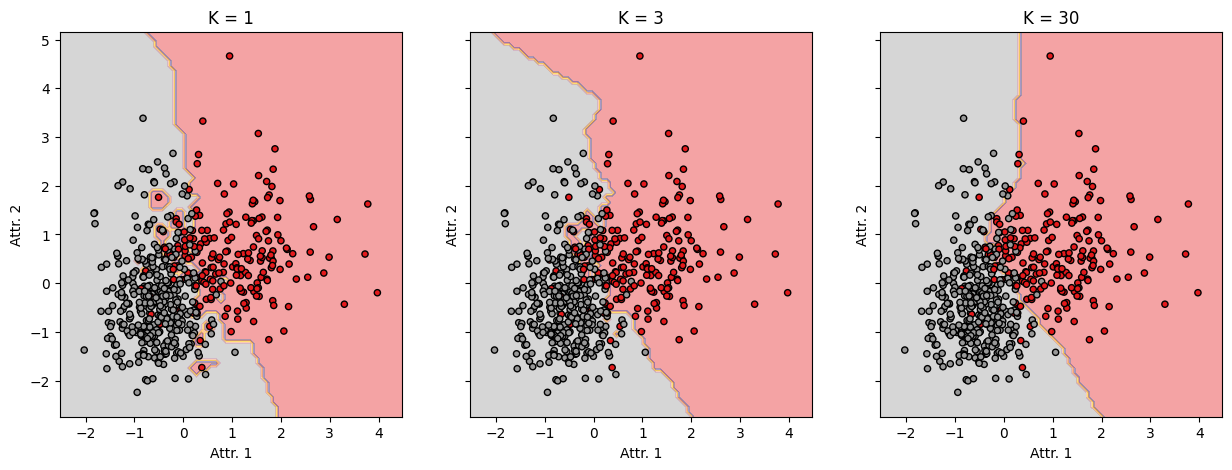

In [24]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))

for i in range(len(knn_classifiers)):

    Z = knn_classifiers[ i ].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[i].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
    axarr[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, edgecolor='k',\
        cmap=plt.cm.Set1)
    axarr[i].set_title('K = ' + str(k[ i ]))
    axarr[i].set_xlabel('Attr. 1')
    axarr[i].set_ylabel('Attr. 2')

plt.show()

We can observe that the value of K has a strong effect on the degree of smoothing. Small values of K produce many regions of each class, while large K leads to fewer regions. K plays the role of a regularization parameter which determines the flexibility of the classifier.

## A Practical Example of the Use of KNN


We now evaluate the performance of the KNN classifier on another dataset. For this, we consider the Insurance Company Dataset. In this dataset the task of interest is to predict whether or not a customer will buy an insurance policy for his or her caravan, given several descriptive attributes related to the income level, education, etc. This is the example considered in the book "An Introduction to Statistical Learning with Applications in R" to illustrate the use of the KNN classifier. 

First, we load the data. This dataset is online and accessible using a URL.

In [25]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-' + \
    'databases/tic-mld/ticdata2000.txt'
raw_data = urllib.urlopen(url)
data = np.loadtxt(raw_data, delimiter="\t")
X = data[:,: -1]
y = data[:, data.shape[ 1 ] - 1 ].astype(int)

Nex, we randomly split the data into train and test partitions. We use 70% of the data for training and 30% for testing. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.3, random_state=2)

We standardize the data to have zero mean and unit standard deviation.

In [27]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We check the standardization process.

In [28]:
print(np.var(X_train[:,0]))
print(np.var(X_train[:,1]))
print(np.var(X_train_scaled[:,0]))
print(np.var(X_train_scaled[:,1]))

165.46982748315708
0.13101427979976663
1.000000000000009
0.9999999999999828


We print some summary of the classes in the dataset.

In [29]:
print('Fraction of negative examples in train: %f' % (np.mean(y_train == 0)))
print('Fraction of negative examples in test: %f' % (np.mean(y_test == 0)))

Fraction of negative examples in train: 0.939632
Fraction of negative examples in test: 0.941614


We can observe that this dataset is highly unbalanced as the fraction of negative examples (i.e., those records without any associated caravan insurance policy) is near 94%. 

We train several Knn classifiers on the data for K = [1, 3, 5, 9]. And compute the resulting performance using different metrics.


In [30]:
k = [ 1, 3, 5, 9 ]
knn_classifiers = [ KNeighborsClassifier(n_neighbors=x) for x in k ]

for i in range(len(knn_classifiers)):

    knn_classifiers[ i ].fit(X_train_scaled, y_train)
    y_pred = knn_classifiers[ i ].predict(X_test_scaled)
    conf = confusion_matrix(y_test, y_pred)

    # The matrix conf contains:
    # TN | FN
    # FP | TP

    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]

    print('K = %d. Predicion accuracy is: %f' % (k[ i ], \
        (TP + TN) / (TN + TP + FP + FN)))
    print('K = %d. Accuracy within the positives: %f\n' % (k[ i ], \
        TP / (TP + FP)))


K = 1. Predicion accuracy is: 0.894104
K = 1. Accuracy within the positives: 0.104762

K = 3. Predicion accuracy is: 0.925587
K = 3. Accuracy within the positives: 0.166667

K = 5. Predicion accuracy is: 0.938180
K = 5. Accuracy within the positives: 0.312500

K = 9. Predicion accuracy is: 0.941042
K = 9. Accuracy within the positives: 0.000000



The estimated prediction accuracy on the test set is not very impressive. This dataset is highly unbalanced and predicting always a negative class will result in an accuracy above 94%. However, if we take a look at which examples from the ones predicted as positive are actually positive, we observe that the KNN classifier is able to extract some patterns from the training set. The rate from always predicting positive examples is around 6%. KNN is hence finding some patterns in a difficult data set since the true positive rate with K = 5 is nearly 30%, much higher. With K = 9 the true positive rate goes to zero.

Most likely, there is some cost to trying to sell insurance to a given individual. A salesperson should probably visit each potential customer. If the company tries to sell insurance to a random selection of customers, then the success rate will be only around 6%, which may be far too low given the costs involved. 

Instead, the company may do better by trying to sell insurance only to customers who are likely to buy it. A KNN classifier with K = 5 can identify a small subset of persons in which the chance that they buy an insurance is nearly 30%.